In [316]:
from typing import Dict, List, Tuple, Union, Any, Optional

from functools import partial
import itertools as it

import pandas as pd
import numpy as np
import datetime as dt
import os, sys

from pathlib import Path

import torch
import ray
from ray import train, tune

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm import tqdm
from wrapt_timeout_decorator import timeout

from src.datasets import daocensus_text
from src.utils import Timer
from src.utils import notebooks as nbutils
from src import paths

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Parameters

In [317]:
JOBLIB_CACHE_DIR = './.cache/11_pln-tune'

TRANSFORMER_MODEL = "all-mpnet-base-v2"
ORG_NAME = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = False

# Evaluation
# N_SPLITS: int = 10
# SKIP_SPLIT: int = 0
K_RECOMMENDATIONS: List[int] = [5, 10]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_SPLITS = 10 # Use just last 10 splits

# Metrics Dataframe
MDF_FILE = paths.pln_mdf(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
GRAPHS_METRIC = 'map@10'

# k for K Nearest Neighbors
# KNN_K: int = 1

In [318]:
# dfptext = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfv['voter'] = dfv['voter'].astype('str')
# dfp = dfp.merge(dfptext, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
dfv[['voter', 'proposal']] = dfv[['voter', 'proposal']].astype(str)
dfp[['id']] = dfp[['id']].astype(str)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Warning, removing 116560 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  object        
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  object        
 7   date           116560 non-null  datetime64[ns]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 9.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1943 entries, 0f4784fc-022a-5047-8bfe-e16ac3bd0984 to 629184e6-f8b2-5270-b358-252369d7599d
Data 

## Getting the embeddings of each proposal

In [319]:
from sentence_transformers import SentenceTransformer
import pickle

str(model)
```
SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)
```

hash(str(model)) = 1078797550815066609

In [320]:
model = SentenceTransformer(TRANSFORMER_MODEL)

In [321]:
from src.models.nlp import get_embeddings_from_cache

model = SentenceTransformer(TRANSFORMER_MODEL)
print(model)
embeddings = get_embeddings_from_cache(dfp, model)

# We have to delete the model because it complains about forking
del model
# ids = embeddings.index

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)
All embeddings are already calculated


In [322]:
embeddings_sum = embeddings.sum(axis=0)
print(embeddings.shape, embeddings_sum.shape)
embeddings = embeddings.apply(lambda x: x / embeddings_sum)
embeddings

(1943,) (768,)


id
0f4784fc-022a-5047-8bfe-e16ac3bd0984    [0.00024967678, 0.0006414138, 0.0008391258, 0....
1076afc9-898c-5e2c-b935-e4098697078e    [0.001466545, 0.00030541283, 0.00033589837, 0....
0040ba5e-10b9-500d-820d-565469375c2a    [-0.0010839765, 0.00088614103, 0.0005159463, -...
887be0e6-8878-5611-9f66-a5838dd89ee0    [0.0008752301, 0.0005821871, 0.00061497354, -0...
b6ba1508-89f8-5f1b-8b52-209f21ab8f7e    [-0.0015600688, -4.7829955e-05, 0.00069438305,...
                                                              ...                        
4558ea33-ee07-5334-beac-707b923bb3f3    [0.0007028783, 0.00017008178, -4.044708e-05, 0...
e7604960-a60b-556b-b677-5c91a78cd88f    [-0.0004782006, 3.6241845e-06, 0.0006607393, 0...
b32ce381-23e2-538b-8ff9-33205b457c22    [0.0013822797, 0.0007584231, 0.00033487612, 0....
974d8a2c-8955-529f-96ed-061fa500bf33    [0.0015055725, 0.00046790336, 0.00041753572, -...
629184e6-f8b2-5270-b358-252369d7599d    [-0.00066695624, -0.00019068179, 0.0007338731,...
Length:

In [323]:
dfp['embeddings'] = embeddings

## Getting the embeddings of each user

The embeddings of each user are the embeddings of each proposal the user has voted in

In [324]:
# dfp['nbidx'] = dfp.index
# _dfv = dfv.merge(dfp[['id', 'nbidx']], how='left', left_on='proposal', right_on='id')
# print('dfp:', dfp.shape, 'dfv:', dfv.shape, '_dfv:', _dfv.shape)
# votes_embeddings = embeddings[_dfv['nbidx']]
votes_embeddings = embeddings.loc[dfv['proposal']]
print('dfp:', dfp.shape, 'dfv:', dfv.shape)
votes_embeddings.shape

dfp: (1943, 13) dfv: (116560, 10)


(116560,)

In [325]:
x=np.array([3,4])
x = x / np.linalg.norm(x)
print(x)
print(np.linalg.norm(x))
print(x.sum())

[0.6 0.8]
1.0
1.4


In [326]:
# observed = True, because voter is categorical and might have no votes really
voter_embeddings = dfv.groupby('voter', observed=True).apply(lambda x: votes_embeddings[x.index].sum(axis=0))
voter_embeddings = voter_embeddings.apply(lambda x: x/np.linalg.norm(x))
# msk = (np.linalg.norm(np.stack(voter_embeddings.to_numpy()), axis=1) > 0.9)
voter_embeddings

voter
0x0019220ddabe5b8438a6be6ebca31ef01ca69965    [0.0010477987, 0.0015924382, 0.0017050041, 0.0...
0x0023a0bf1cb20362f847dfc977d2c815f6ac8021    [0.009622099, 0.0034187052, 0.003367807, 0.006...
0x0026dd985da16f70e9d9cf739b08c6cdf6a7f407    [0.0015011001, 0.0011227258, 0.00052121805, 0....
0x0029ab135b5be72168bf80f140d60a9264dbd0c5    [0.0018051072, 0.0007161274, 0.0008733617, 0.0...
0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34    [0.0037666145, 0.002783243, 0.002651312, 0.002...
                                                                    ...                        
0xffd92144cafd599a5a93e4805ca4d8f0e666d623    [0.0037441235, 0.003186649, 0.00280605, 0.0035...
0xffd9cd75445459184a4b89a0fbd1720ab2957738    [0.0027223164, 0.003114445, 0.00163464, 0.0030...
0xffe6d9d29480d0673c4fc46da22d21e245c8e731    [0.0056425673, 0.003079375, 0.0010376757, 0.00...
0xffed2f64c9f796d4258618a7a375ed816205821a    [-0.00048470704, 0.0008324865, 0.0009201956, 0...
0xfff28923092a8294456206a6d0734514

In [327]:
dfv.groupby('voter', observed=True).size().sort_values()

voter
0x7dc3331bc545a41e566dfbbb3d8851bf4762486f      1
0x7ae0a65d329bc202e83a360d9afc880063c12337      1
0x7b07608c3e4ef235c7a5e15f02a7fa9552ce113f      1
0x7b29be2f106712287024e6228e015d44cdfa0dec      1
0x7b2ec1a291a0a4dd08d65ab34a62bda1cca618c6      1
                                             ... 
0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8    652
0xd6eff8f07caf3443a1178407d3de4129149d6ef6    727
0xb44ac514588be99870220d12120815bc3d349507    729
0x521b0fef9cdcf250abaf8e7bc798cbe13fa98692    760
0xc54a6c3778016b06cbd126ccc3b5bc06c5f666fb    885
Length: 7268, dtype: int64

## Making recommendations with cosine similarity

Because they are normalized, our ranking score can be just the dot product of a user and a proposal

In [328]:
user_emb = voter_embeddings['0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8']
embeddings_np = np.vstack(embeddings)
scores = embeddings_np @ user_emb
scores.argsort()

array([1623,  480, 1504, ..., 1045, 1092,  107])

In [329]:
list(range(10))[-3:]

[7, 8, 9]

In [330]:
def recommend_emb(emb, k, t = None):
    """
    Args:
        emb: The embedding of the item/user to recommend items to
        k (int): The number of items to recommend
        t (timestamp): Simulate that the recommendation is made at time `t`
            i.e: Filter out already closed proposals or not yet open
    """
    # 1D n_proposals
    scores = embeddings_np @ emb

    if t:
        msk = (dfp['start'] < t) & (t < dfp['end'])
        scores[msk] = -np.inf
    
    best = (-scores).argsort()

    dfbest = dfp.iloc[best[:k]].copy()
    dfbest['score'] = scores[best[:k]]
    return dfbest

In [331]:
def recommend_user(voter: str, k: int = 5, t: Optional[np.datetime64] = None):
    # 1D emb_size
    user_emb = voter_embeddings[voter]
    return recommend_emb(user_emb, k, t)

recommend_user('0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8')[['title', 'description', 'score']]

,title,description,score
id,,,
475ef4ab-4320-5832-b12f-59222f3f41b5,Should Voter Power Delegation be activated in ...,> by 0x9982b469910c2ee2ea566dcfcc250cdd3405639...,1.842545
52d72c94-bc54-5cc3-b201-c8789538df84,Should the DAO implement a mechanism to delega...,> by 0x511a22cdd2c4ee8357bb02df2578037ffe8a4d8...,1.782764
11946f30-e09f-5638-be0a-82dff99d3112,Logarithmic VP conversion after a certain amou...,> by 0x5985eb4a8e0e1f7bca9cc0d7ae81c2943fb205b...,1.776113
bc3ec30e-b7f7-5de5-aa8e-8acf9d430887,Should Voter Power delegation be activated in ...,> by 0x3fb38cee8d0ba7dcf59403a8c397626dc9c7a13...,1.674607
d3340f4d-a402-5844-9460-8c9fbcca770c,Should VP keep assigned to the landowner in a ...,> by 0x87956abc4078a0cc3b89b419928b857b8af826e...,1.664069


In [332]:
def recommend_proposal(proposal: str, k: int = 5, t: Optional[np.datetime64] = None):
    # 1D emb_size
    prop_emb = dfp['embeddings'][proposal]
    return recommend_emb(prop_emb, k, t)

display(dfp.loc['433b7e43-77b0-5ea1-bac3-0c3071363a56'])
recommend_proposal('433b7e43-77b0-5ea1-bac3-0c3071363a56')

platform                                                        snapshot
name                                                        Decentraland
platform_deployment                                     snapshot.dcl.eth
deployment                          41fd8de5-f8e2-5023-86a3-825c49e9ad7f
platform_proposal      0xdbe9b2df1d00c0d264bffb3f10f1332a82d8a8a70c12...
author                        0xbb7b59afa3a0e5be143b8fe9c641f00c1ecb9d69
date                                                 2023-02-14 16:19:06
votes_count                                                          385
title                  Should DAO proposals have a pre-defined 'Absta...
description            > by 0x511a22cdd2c4ee8357bb02df2578037ffe8a4d8...
start                                                2023-02-14 16:19:00
end                                                  2023-02-28 16:19:00
embeddings             [-0.00036658134, 0.00013961297, -0.00012315909...
Name: 433b7e43-77b0-5ea1-bac3-0c3071363a56, dtype: 

,platform,name,platform_deployment,deployment,platform_proposal,author,date,votes_count,title,description,start,end,embeddings,score
id,,,,,,,,,,,,,,
bc3ec30e-b7f7-5de5-aa8e-8acf9d430887,snapshot,Decentraland,snapshot.dcl.eth,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,QmdBJnZuaEnt2gYahqKYRctvA4saDN3mjKxLTnKvrSPaUn,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2021-05-26 00:04:49,96,Should Voter Power delegation be activated in ...,> by 0x3fb38cee8d0ba7dcf59403a8c397626dc9c7a13...,2021-05-26 00:04:00,2021-06-02 00:04:00,"[-0.0003346699, 0.00049384136, 6.674624e-05, -...",1.152099
571a60f9-3a00-5bca-8a2d-ae55131dfab2,snapshot,Decentraland,snapshot.dcl.eth,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,0xffae5e552f74e34f3d9fb52bfbdeda55d1316be9f5d9...,0xbb7b59afa3a0e5be143b8fe9c641f00c1ecb9d69,2023-03-07 10:56:21,130,Should Grant Request Proposals require at leas...,> by 0x0636211443e91468ee3657e1d7faede7059c484...,2023-03-07 10:56:00,2023-03-12 10:56:00,"[0.0009157116, 0.00040869717, -8.947684e-06, 0...",1.135156
f9f72c2d-3b52-5613-bda1-9016182a156e,snapshot,Decentraland,snapshot.dcl.eth,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,QmcMjpHApC2FJcGydAQKF5p86gueZ5jDaMYiPgr2Qfx43r,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2021-06-02 22:48:00,38,A proposal for minimum VP participation thresh...,> by 0x9982b469910c2ee2ea566dcfcc250cdd3405639...,2021-06-02 22:48:00,2021-06-09 22:48:00,"[0.0003464241, 0.00028029148, 0.00018712915, -...",1.104726
52d72c94-bc54-5cc3-b201-c8789538df84,snapshot,Decentraland,snapshot.dcl.eth,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,0x2ee03d9a8ee8afc10919d24f5d700c5f161691624aac...,0xbb7b59afa3a0e5be143b8fe9c641f00c1ecb9d69,2023-01-10 17:02:51,164,Should the DAO implement a mechanism to delega...,> by 0x511a22cdd2c4ee8357bb02df2578037ffe8a4d8...,2023-01-10 17:02:00,2023-01-15 17:02:00,"[0.0012971687, 0.00042636564, 0.000442586, -0....",1.069899
a0eab868-d07e-5ef9-97cb-9633382f07e9,snapshot,Decentraland,snapshot.dcl.eth,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,QmeCP5vd6NguABv7mJQDv2pcFRnvRKnpVywALDCwvumJjj,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2021-12-25 15:55:29,17,Do you think the application fee for a collect...,> by 0xdd8e8b66613cb347cf2460f692894554836f76e...,2021-12-25 15:55:00,2022-01-01 15:55:00,"[0.001745783, 0.00045877005, -0.00027697685, 6...",1.038014


### Evaluation

First, we will evaluate if the user recommendations are any good using common off-line metrics.

In [333]:
assert not any(voter_embeddings.isna()), "Hay embeddings NA"

In [334]:
np.vstack(voter_embeddings)

array([[ 0.0010478 ,  0.00159244,  0.001705  , ..., -0.00262108,
         0.00302399,  0.00773245],
       [ 0.0096221 ,  0.00341871,  0.00336781, ...,  0.00259694,
        -0.00398165, -0.01983549],
       [ 0.0015011 ,  0.00112273,  0.00052122, ...,  0.00062561,
         0.00074369, -0.00352989],
       ...,
       [ 0.00564257,  0.00307938,  0.00103768, ...,  0.01294672,
         0.00525271,  0.00549167],
       [-0.00048471,  0.00083249,  0.0009202 , ...,  0.0044537 ,
         0.00167882, -0.00284087],
       [ 0.00086909,  0.0006073 ,  0.00085035, ..., -0.00171215,
         0.00043571,  0.00923104]], dtype=float32)

In [335]:
def recommendNLPNaive(train: pd.DataFrame, users, proposals, k: int = 5, remove_training: bool = True, min_score: float = 0):  
    # Create voter embeddings (filtering that they are in train)
    # TODO: Add some kind of discount rate over time
    # TODO: DELETEME
    aux = dfv[dfv['voter'].isin(users) & dfv['proposal'].isin(train['itemID'])]
    not_in_train = set(users).difference(dfv[dfv['proposal'].isin(train['itemID'])]['voter'])
    # print('aux.shape:', aux.shape)
    # print('not in train (in):', len(not_in_train))

    voter_embeddings = aux.groupby('voter', observed=True).apply(lambda x: votes_embeddings[x.index].sum(axis=0))
    voter_embeddings = voter_embeddings.apply(lambda x: x/np.linalg.norm(x))
    # np_voter_embeddings = np.stack(voter_embeddings.to_numpy())
    np_voter_embeddings = np.vstack(voter_embeddings)
    
    # Remove score from proposals not in `proposals`
    msk = embeddings.index.isin(proposals)
    tr_embeddings = np.vstack(embeddings).copy()
    tr_embeddings[~msk] = 0
    
    scores = np_voter_embeddings @ tr_embeddings.T
    
    # Remove score from proposals already voted by user
    if remove_training:
        trainu = train[train['userID'].isin(users)]
        itemID2idx = pd.Series(data=np.arange(len(dfp)), index=dfp.index.astype(str))
        voterID2idx = pd.Series(data=np.arange(len(voter_embeddings)), index=voter_embeddings.index)
        scores[voterID2idx[trainu['userID']], itemID2idx[trainu['itemID']]] = -np.inf
        
    best = (-scores).argsort(axis=1)
    topk = best[:, :k]
    
    # create df with columns
    # userID, itemID, prediction
    uid = np.repeat(np.arange(np_voter_embeddings.shape[0]), k)
    iid = topk.flatten()
    
    # transform int to id
    df = pd.DataFrame({
        'userID': voter_embeddings.index[uid],
        'itemID': dfp.index[iid].astype(str),
        # 'prediction': 1,
        'prediction': scores[uid, iid],
    })
    return df[df['prediction'] > min_score].reset_index(drop=True)

# train = train_filtered
# users = test_filtered['userID'].unique()
# proposals = test_filtered['itemID'].unique()
# k = 3
# remove_training = True

In [336]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from src.datasets import to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent

In [337]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

### Evaluation in multiple months

In [338]:
df = to_microsoft(dfv)
folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'))[-LAST_SPLITS:]
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, } # 'recall': recall_at_k, 

def testHParamsSimilarity(fold, window_size):
    metrics = dict()

    train, test, t, open_proposals = folds[fold]
    offset = pd.tseries.frequencies.to_offset(window_size)

    train_filtered = train[train['timestamp'] > (t - offset)]
    not_in_train = set(test['userID']).difference(train['userID'])
    # print('not in train:', len(not_in_train))
    # print('not in train filtered:', len(not_in_train))
    for k_recs in K_RECOMMENDATIONS:
        with Timer() as t:
            recs = recommendNLPNaive(train_filtered, test['userID'].unique(), open_proposals, k_recs)

        metrics[f'time@{k_recs}'] = t.time
        for m, f in metrics_f.items():
            metrics[m+f'@{k_recs}'] = f(test, recs, k=k_recs)

    return metrics

testHParamsSimilarity(0, '14d')
testHParamsSimilarity(1, '2W')

{'time@5': 0.041011521592736244,
 'precision@5': 0.32244897959183677,
 'ndcg@5': 0.41754244844097116,
 'map@5': 0.2336587905434786,
 'time@10': 0.04062001034617424,
 'precision@10': 0.2789115646258503,
 'ndcg@10': 0.49648541948904495,
 'map@10': 0.319728133386384}

In [339]:
from sklearn.model_selection import ParameterGrid

param_grid = ParameterGrid({
    'fold': range(len(folds)),
    'window_size': ['7d', '14d', '30d', '90d', '180d', '360d', '10Y'],
})

results = list()
for p in tqdm(param_grid):
    results.append(testHParamsSimilarity(**p) | p)

mdf = pd.DataFrame(results).set_index(['fold', 'window_size'])
mdf

100%|███████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.56it/s]


time@5  precision@5    ndcg@5     map@5   time@10  \
fold window_size                                                        
0    7d           0.031708     0.307692  0.677264  0.575874  0.035641   
     14d          0.038434     0.335385  0.711873  0.621285  0.038195   
     30d          0.043364     0.316923  0.666032  0.578733  0.043750   
     90d          0.052740     0.295385  0.641433  0.565650  0.055927   
     180d         0.065671     0.287692  0.628058  0.548477  0.067019   
...                    ...          ...       ...       ...       ...   
9    30d          0.039124     0.273759  0.598138  0.475326  0.038931   
     90d          0.045133     0.250000  0.519065  0.400859  0.047564   
     180d         0.053525     0.221429  0.463694  0.351438  0.057664   
     360d         0.069115     0.214184  0.443070  0.336515  0.071646   
     10Y          0.081117     0.212766  0.416806  0.310212  0.084223   

                  precision@10   ndcg@10    map@10  
fold window_size                                    
0    7d               0.216154  0.753695  0.645062  
     14d              0.213846  0.750625  0.664721  
     30d              0.209231  0.715713  0.625070  
     90d              0.205385  0.706828  0.618423  
     180d             0.200000  0.692730  0.598643  
...                        ...       ...       ...  
9    30d              0.185106  0.643413  0.516595  
     90d              0.181429  0.583986  0.451085  
     180d             0.167857  0.528678  0.399566  
     360d             0.160993  0.502920  0.380409  
     10Y              0.153191  0.470651  0.349726  

[70 rows x 8 columns]

<Axes: xlabel='fold', ylabel='precision@5'>

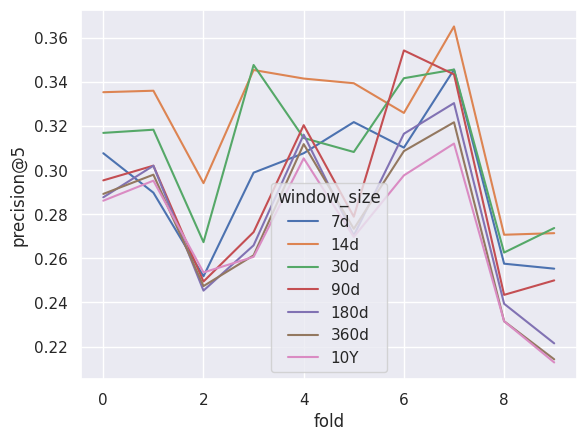

In [340]:
sns.lineplot(mdf, x='fold', y='precision@5', hue='window_size')

In [341]:
mdf.groupby('window_size').describe().drop(columns=['time@10', 'ndcg@10']).T

window_size               10Y        14d       180d        30d       360d  \
time@5       count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.084628   0.035973   0.061285   0.039138   0.074060   
             std     0.005389   0.003399   0.004731   0.003420   0.004964   
             min     0.079787   0.031945   0.053525   0.034081   0.068030   
             25%     0.081119   0.033275   0.058452   0.036763   0.070867   
             50%     0.082800   0.035239   0.061733   0.038942   0.072763   
             75%     0.085909   0.038167   0.064309   0.042130   0.075908   
             max     0.097310   0.041590   0.068746   0.044156   0.083455   
precision@5  count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.272474   0.322537   0.279530   0.309700   0.275726   
             std     0.032896   0.032423   0.036964   0.032006   0.036424   
             min     0.212766   0.270707   0.221429   0.262626   0.214184   
             25%     0.255375   0.302084   0.250498   0.282383   0.250908   
             50%     0.277939   0.335720   0.279031   0.315765   0.281313   
             75%     0.297038   0.341042   0.312607   0.335891   0.305986   
             max     0.312088   0.365217   0.330435   0.347727   0.321739   
ndcg@5       count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.458658   0.599916   0.479677   0.556042   0.467848   
             std     0.097225   0.098421   0.103111   0.107094   0.100632   
             min     0.356672   0.448304   0.374584   0.415286   0.360972   
             25%     0.381409   0.545807   0.401976   0.484915   0.387111   
             50%     0.428062   0.584547   0.452945   0.508449   0.433835   
             75%     0.526499   0.665531   0.558443   0.649058   0.545273   
             max     0.614903   0.770386   0.644778   0.720778   0.625689   
map@5        count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.347681   0.475615   0.365457   0.435068   0.356537   
             std     0.116367   0.125824   0.122311   0.129867   0.118954   
             min     0.195649   0.261915   0.208014   0.235082   0.200218   
             25%     0.276412   0.407905   0.282146   0.352086   0.283848   
             50%     0.314640   0.459160   0.331446   0.395252   0.320964   
             75%     0.423265   0.549955   0.451963   0.552881   0.438842   
             max     0.532992   0.690269   0.558769   0.633041   0.543986   
precision@10 count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.195118   0.220855   0.201693   0.216568   0.198480   
             std     0.026843   0.028875   0.024860   0.025835   0.025320   
             min     0.153191   0.187857   0.164773   0.185106   0.159091   
             25%     0.183111   0.206440   0.187091   0.201630   0.185038   
             50%     0.197845   0.211271   0.202717   0.211702   0.202076   
             75%     0.206711   0.222368   0.214715   0.225600   0.211016   
             max     0.244898   0.291156   0.244218   0.275510   0.238776   
map@10       count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.400634   0.529367   0.420295   0.491717   0.410567   
             std     0.113013   0.112951   0.120189   0.120381   0.117421   
             min     0.268910   0.353385   0.274256   0.318340   0.265625   
             25%     0.328330   0.457654   0.352846   0.411649   0.335887   
             50%     0.356569   0.512852   0.375021   0.452991   0.371118   
             75%     0.479161   0.595768   0.506796   0.597951   0.492893   
             max     0.582670   0.727703   0.613936   0.680481   0.595367   

window_size                7d        90d  
time@5       count  10.000000  10.000000  
             mean    0.031485   0.050029  
             std     0.003132   0.003438  
             min     0.028211   0.045133  
           

In [342]:
from src import paths

bdf = pd.read_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))[-LAST_SPLITS:]
bdf['fold'] = np.arange(10)
bdf.describe()

,precision@5,ndcg@5,map@5,precision@10,ndcg@10,map@10,precision@15,ndcg@15,map@15,fold
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000
mean,0.242239,0.359232,0.273718,0.203414,0.452635,0.347708,0.172498,0.511909,0.381484,4.50000
std,0.047466,0.068965,0.074055,0.036372,0.094494,0.085371,0.025276,0.078546,0.073792,3.02765
min,0.175887,0.261361,0.160324,0.154610,0.345760,0.237655,0.147826,0.391861,0.282710,0.00000
25%,0.204670,0.312815,0.208174,0.171720,0.374541,0.271677,0.151094,0.456366,0.315863,2.25000
50%,0.239654,0.362439,0.282355,0.201566,0.441804,0.346455,0.167426,0.508512,0.384349,4.50000
75%,0.274518,0.406027,0.340138,0.234006,0.515205,0.422546,0.183131,0.587780,0.448962,6.75000
max,0.316854,0.472241,0.360832,0.255056,0.600927,0.457227,0.222222,0.613269,0.474586,9.00000


In [343]:
pdf = pd.read_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))[-LAST_SPLITS:]
pdf['fold'] = np.arange(10)
pdf.describe()

,precision@5,ndcg@5,map@5,precision@10,ndcg@10,map@10,precision@15,ndcg@15,map@15,fold
count,10.000000,10.0,10.000000,10.000000,10.0,10.000000,10.000000,10.0,10.000000,10.00000
mean,0.477679,1.0,0.947617,0.280511,1.0,0.989408,0.195757,1.0,0.998196,4.50000
std,0.057337,0.0,0.037965,0.053225,0.0,0.014943,0.045954,0.0,0.003290,3.02765
min,0.429231,1.0,0.855537,0.221739,1.0,0.954973,0.147826,1.0,0.991713,0.00000
25%,0.436919,1.0,0.946627,0.252551,1.0,0.987960,0.174627,1.0,0.999060,2.25000
50%,0.455723,1.0,0.958442,0.264085,1.0,0.996370,0.180812,1.0,0.999778,4.50000
75%,0.498877,1.0,0.963772,0.295833,1.0,0.998967,0.199394,1.0,1.000000,6.75000
max,0.597279,1.0,0.993271,0.414286,1.0,1.000000,0.313832,1.0,1.000000,9.00000


Cannot show ipywidgets in text

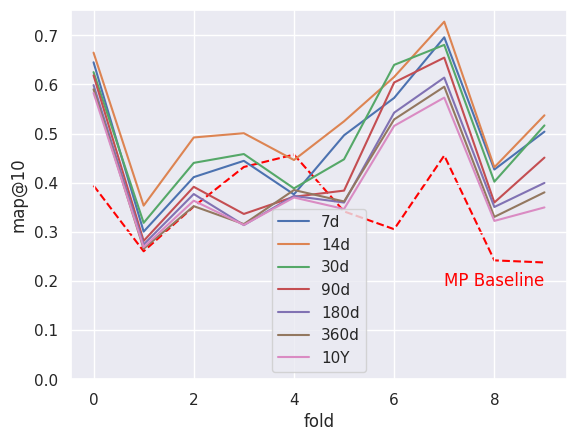

In [344]:
_METRICS = ['map@5', 'map@10']
_METRIC = _METRICS[-1]

ax = sns.lineplot(mdf, x='fold', y=_METRIC, hue='window_size')
ax = sns.lineplot(bdf, x='fold', y=_METRIC, color='red', zorder=0)
ax.lines[-1].set_linestyle('--')
ax.text(9, 0.19, "MP Baseline", ha='right', color=ax.lines[-1].get_color())

# ax = sns.lineplot(pdf, x='fold', y=_METRIC, color='blue')
# ax.lines[-1].set_linestyle(':')

ax.set_ylim((0,None));
nbutils.download_matplotlib(ax.figure, f'11_cosine_results_results-lines_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

<class 'matplotlib.figure.Figure'>


Cannot show ipywidgets in text

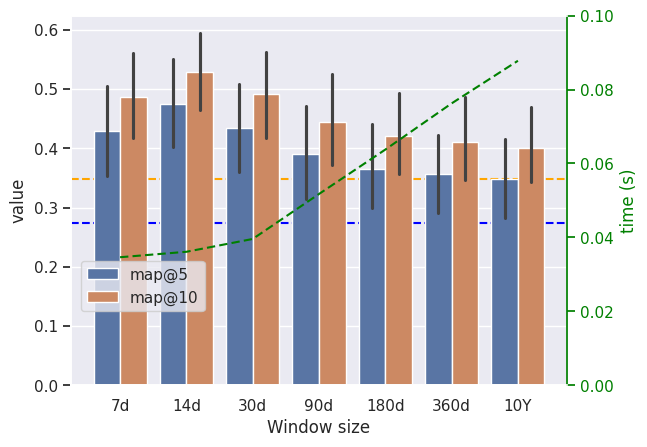

<Figure size 640x480 with 0 Axes>

In [345]:
# _METRIC = 'precision@5'

topline = pdf[_METRIC].mean()

_toplot = mdf[_METRICS].melt(value_vars=_METRICS, var_name='metric', ignore_index=False)

sns.set_theme()
ax = sns.barplot(_toplot, x='window_size', y='value', hue='metric')
ax.set_xlabel("Window size")

baseline = bdf[_METRICS[0]].mean()
ax.axhline(baseline, ls='--', color='blue', zorder=0)
baseline = bdf[_METRICS[1]].mean()
ax.axhline(baseline, ls='--', color='orange', zorder=0)
# ax.text(0, baseline-0.005, "map@5", color='black', ha='left', va='top', fontsize='large')

if not _METRIC.startswith('map@'):
    ax.axhline(topline, ls=':', color='blue')
    ax.text(0, topline-0.005, "perfect", color='blue', ha='left', va='top')

ax2 = ax.twinx()
time_color = 'green'
sns.lineplot(mdf, x='window_size', y='time@10', color=time_color, ax=ax2, markers=True, dashes=(4,2), errorbar=None)
ax2.set_ylabel('time (s)', color=time_color)
ax2.tick_params(axis='y', color=time_color)
ax2.spines['right'].set_color(time_color)
[t.set_color(time_color) for t in ax2.yaxis.get_ticklabels()]
ax2.grid(False)
ax2.set_ylim((0,.10))

ax.legend(loc=(0.02,.2))

print(type(plt.figure()))
nbutils.download_matplotlib(ax.figure, f'11_cosine_results_window-size_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

# Second iteration: PLN with kNN

In [346]:
from sklearn.neighbors import KNeighborsClassifier

# itemID2idx = pd.Series(data=np.arange(len(dfp)), index=dfp.index.astype(str))
# itemID2idx

In [347]:
def filter_proposals_in_train(train, user, proposals):
    msk = train['userID'] == user
    proposals_aready_voted_by_user = train[msk]['itemID'].unique()
    return np.setdiff1d(proposals, proposals_aready_voted_by_user)

In [348]:
from joblib import Memory

# memory = Memory(JOBLIB_CACHE_DIR, mmap_mode='c', verbose=0)

# @memory.cache
def recommendUserKNN(train: pd.DataFrame, user, proposals, top_k: Optional[int] = None, knn_k = 3, do_sampling: Optional[bool] = None, remove_train: bool = True, metric=None):
    """
    Given the train data (proposals that might be voted or not by the user), recommend k proposals from proposals to the user
    The train data is a DataFrame in microsoft's format
    
    do_sampling (bool) : default None
        if True, makes sampling so the number of positive and negative samples is the same
        if False, doesn't do it
        if None (default), does it when k > 0, but doesn't do it with Nearest Neighbor
    """
    # train['hasVoted'] = train['userID'] == user
    hasVoted = train['userID'] == user

    # Remove recommendations already in training
    # (aka remove from proposals array)
    if remove_train:
        proposals = filter_proposals_in_train(train, user, proposals)

    assert any(hasVoted), 'The user has not voted in any proposal'
    if knn_k == 0:
        do_sampling = False
        knn_k = 1

    if do_sampling or (do_sampling is None and knn_k > 0):
        # num_samples = train['hasVoted'].value_counts().min() # [True]
        num_samples = hasVoted.value_counts().min() # [True]
        train = train.groupby(hasVoted).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)
        hasVoted = train['userID'] == user

    # known_embeds = embeddings[itemID2idx[train['itemID']]]
    known_embeds = np.vstack(embeddings.loc[train['itemID']])

    assert knn_k >= 0
    knn = KNeighborsClassifier(max(knn_k, 1), metric=metric if metric else 'minkowski')
    knn.fit(known_embeds, hasVoted)# train['hasVoted'])

    predict_embeds = np.vstack(embeddings.loc[proposals])
    aux = knn.predict_proba(predict_embeds)
    p = knn.predict_proba(predict_embeds)[:, 1] # Probabilidad de que sea True

    if top_k:
        best = (1-p).argsort()[:top_k]
        p = p[best]
        proposals = proposals[best]
    
    return pd.DataFrame({
        'userID': user,
        'itemID': proposals,
        'prediction': 1,
        'score': p,
    })

# u = '0xe44782afe398800d7190796018c4b865e32ff806'
# proposals_voted_by_user = test_filtered[test_filtered['userID'] == u]
# print(f'The user {u} voted in {len(proposals_voted_by_user)} proposals')
# p = recommendUserKNN(train, u, test_filtered['itemID'].unique().copy(), 5, do_sampling=True)
# p['correct'] = p['itemID'].isin(proposals_voted_by_user['itemID'])
# p

In [349]:
from recommenders.datasets.pandas_df_utils import filter_by

def recommendMostVoted(train: pd.DataFrame, user, proposals, top_k: Optional[int] = None, remove_train=True):
    bestVotes = train[train['itemID'].isin(proposals)]['itemID'].value_counts()
    df = pd.DataFrame({
        'userID': user,
        'itemID': bestVotes.index,
        'prediction': 1,
        'score': bestVotes,
    })
    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
    return df.head(top_k).reset_index(drop=True)

# u = '0xe44782afe398800d7190796018c4b865e32ff806'
# proposals_voted_by_user = test_filtered[test_filtered['userID'] == u]
# print(f'The user {u} voted in {len(proposals_voted_by_user)} proposals')
# recommendMostVoted(train_filtered.copy(), u, test_filtered['itemID'].unique(), 5)

In [350]:
# import multiprocessing as mp
# from multiprocessing import Pool
# from multiprocessing.pool import ThreadPool as Pool

from joblib import Parallel, delayed

def recommendUserKNNwithFallback(train, user, proposals, top_k = None, knn_k: int = 1, remove_train: bool = True, do_sampling = None, metric=None):
    """ If the user has not voted in any proposal in `train`, we fall back to recommending
    the most voted proposal in `proposals`
    """
    if remove_train:
        proposals = filter_proposals_in_train(train, user, proposals)
    if (user == train['userID']).sum() >= max(knn_k, 1):
        df = recommendUserKNN(train, user, proposals, top_k, knn_k, remove_train=False, do_sampling=do_sampling, metric=metric)
        df['scoreType'] = 'knn'
        return df
    else:
        df = recommendMostVoted(train, user, proposals, top_k, remove_train=False)
        df['scoreType'] = 'mv'
        return df

def recommendNLPKNN(train: pd.DataFrame, users, proposals, top_k: int = 5, knn_k: int = 1, do_sampling=None, cpus=-1, chunksize=8, disable_tqdm=False, metric=None):
    # Create voter embeddings
    assert knn_k >= 0

    # return pd.concat(tqdm((
    #     recommendUserKNNwithFallback(train, u, proposals, top_k, knn_k, remove_train=False, do_sampling=do_sampling) for u in users
    # ), desc='users', leave=False, total=len(users)))

    p = partial(
        recommendUserKNNwithFallback, 
        train, 
        proposals=proposals, 
        top_k=top_k,
        knn_k=knn_k,
        do_sampling=do_sampling,
        metric=metric,
    )

    if cpus == 1:
        # return pd.concat(tqdm(
        return pd.concat(
            map(p, users),
            # total=len(users),
            # desc='users',
            # leave=False,
            # disable=disable_tqdm,
        )
        # ))
    else:
        # with Pool(mp.cpu_count() // 4 if cpus==-1 else cpus) as pool:
        #     return pd.concat(
        #         tqdm(
        #             pool.imap(p, users, chunksize=chunksize),
        #             total=len(users),
        #             desc='users',
        #             leave=False,
        #             disable=disable_tqdm,
        #         )
        #     )
        return pd.concat(
            Parallel()(delayed(p)(u) for u in tqdm(users, desc='users', leave=False, disable=disable_tqdm))
        )

recommendNLPKNN(folds[0][0], folds[0][1]['userID'].unique(), folds[0][1]['itemID'].unique(), top_k=1)

,userID,itemID,prediction,score,scoreType
0,0x2ae9070b029d05d8e6516aec0475002c53595a9d,acb027f2-6bf3-546d-812f-f4d5ca13b308,1,1.0,knn
0,0x52f8d5518a05366989b3baad9c8e1129ca317fc7,acb027f2-6bf3-546d-812f-f4d5ca13b308,1,1.0,knn
0,0xa87d168717538e86d71ac48baccaeb84162de602,29c9f490-088f-5ee5-a211-c9228ef1576b,1,1.0,knn
0,0x9b3ae2dd9eaad174cf5700420d4861a5a73a2d2a,7d0f5566-025f-549f-b3c4-d25f9db69a77,1,1.0,knn
0,0x544a40955ba1c7e56e161a59e1319e3313c25251,7c34f3bf-850d-5ebc-af02-0ea664ac1837,1,1.0,knn
...,...,...,...,...,...
0,0x8d5237037a590a2db531f3cfb8f42605cf306f34,acb027f2-6bf3-546d-812f-f4d5ca13b308,1,1.0,knn
0,0x4534c46ea854c9a302d3dc95b2d3253ae6a28abc,29c9f490-088f-5ee5-a211-c9228ef1576b,1,1.0,knn
0,0x0d269541a5812e1362f47222035cef5dac5466f2,eb828224-cb1c-5177-9171-6d8754307939,1,1.0,knn
0,0xbc9fb2a60f43a3ac7babe3d41f11b04ec439dd42,29c9f490-088f-5ee5-a211-c9228ef1576b,1,1.0,knn


In [351]:
# print(mp.cpu_count())

### Evaluation

Usaremos el método del codo para ver cual de todos es mejor

In [352]:
df = to_microsoft(dfv)
folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', return_open=True))[-LAST_SPLITS:]
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, } # 'recall': recall_at_k, 

def testHParamsKNN(fold, window_size, k, metric, cpus=-1, disable_tqdm=True):
    metrics = dict()

    train, test, t, open_proposals = folds[fold]
    offset = pd.tseries.frequencies.to_offset(window_size)
    train_filtered = train[train['timestamp'] > (t - offset)]

    for k_recs in K_RECOMMENDATIONS:
        with Timer() as t:
            recs = recommendNLPKNN(train_filtered, test['userID'].unique(), open_proposals, k_recs, k, disable_tqdm=disable_tqdm, metric=metric, cpus=cpus)

        metrics[f'time@{k_recs}'] = t.time
        metrics[f'knnUsage@{k_recs}'] = (recs['scoreType'] == 'knn').mean()
        for m, f in metrics_f.items():
                metrics[m+f'@{k_recs}'] = f(test, recs, k=k_recs)

    return metrics

metrics = testHParamsKNN(0, '14d', 0, 'cosine')
metrics

{'time@5': 1.3251330871134996,
 'knnUsage@5': 0.6631205673758865,
 'precision@5': 0.23846153846153842,
 'ndcg@5': 0.4757003808919945,
 'map@5': 0.402456771860618,
 'time@10': 1.3418115191161633,
 'knnUsage@10': 0.623015873015873,
 'precision@10': 0.1876923076923077,
 'ndcg@10': 0.554653974923051,
 'map@10': 0.46378135692146677}

In [353]:
from sklearn.model_selection import ParameterGrid
from tqdm.contrib.concurrent import thread_map as tqdm_map
# from joblib import Memory

# memory = Memory('.cache')

param_grid = ParameterGrid({
    'fold': range(len(folds)),
    'window_size': ['7d', '14d', '30d', '90d', '180d', '360d', '10Y'],
    'k': [1,2,3,4,5,6,7,8,9,10,15,20,30,50],
    'metric': ['minkowski', 'cosine'],
})

# @memory.cache
def retDict(p):
    @timeout(60, use_signals=True, exception_message=f"Timeout testing {p}")
    def aux(p):
        return testHParamsKNN(cpus=1, **p) | p

    return aux(p)

# TODO: Open the pickle file and do only the ones missing

if not MDF_FILE.exists():
    results = tqdm_map(retDict, param_grid, chunksize=4, tqdm_class=tqdm, max_workers=8)
    # results = map(retDict, tqdm(param_grid))
    mdf = pd.DataFrame(results).set_index(['fold', 'window_size', 'k', 'metric'])
    mdf.to_pickle(MDF_FILE)
else:
    mdf = pd.read_pickle(MDF_FILE)
mdf

time@5  knnUsage@5  precision@5    ndcg@5  \
fold window_size k  metric                                                    
0    7d          1  minkowski   0.715958    0.567901     0.198462  0.326336   
     14d         1  minkowski   1.424702    0.663121     0.246154  0.491852   
     30d         1  minkowski   3.456916    0.804965     0.256923  0.498050   
     90d         1  minkowski   4.620585    0.911348     0.258462  0.505591   
     180d        1  minkowski  10.963902    0.973404     0.255385  0.475403   
...                                  ...         ...          ...       ...   
9    30d         50 cosine      1.445616    0.007246     0.177305  0.273249   
     90d         50 cosine      3.739648    0.094203     0.175887  0.270396   
     180d        50 cosine      5.272426    0.195652     0.180142  0.273944   
     360d        50 cosine      9.580760    0.311594     0.184397  0.287051   
     10Y         50 cosine      9.458922    0.362319     0.178723  0.265280   

                                  map@5    time@10  knnUsage@10  precision@10  \
fold window_size k  metric                                                      
0    7d          1  minkowski  0.225888   0.968648     0.550201      0.180000   
     14d         1  minkowski  0.414671   2.046966     0.623016      0.186923   
     30d         1  minkowski  0.417629   3.220958     0.781746      0.183077   
     90d         1  minkowski  0.429721   8.072220     0.900794      0.186154   
     180d        1  minkowski  0.395087  12.341484     0.970238      0.196923   
...                                 ...        ...          ...           ...   
9    30d         50 cosine     0.182667   1.172531     0.003698      0.154610   
     90d         50 cosine     0.182533   2.820981     0.077663      0.154610   
     180d        50 cosine     0.179263   5.385674     0.179734      0.155319   
     360d        50 cosine     0.196764   4.809677     0.297337      0.156028   
     10Y         50 cosine     0.176319   3.453159     0.349112      0.153191   

                                ndcg@10    map@10  
fold window_size k  metric                         
0    7d          1  minkowski  0.392480  0.248820  
     14d         1  minkowski  0.557521  0.472632  
     30d         1  minkowski  0.543316  0.463583  
     90d         1  minkowski  0.557877  0.469521  
     180d        1  minkowski  0.578722  0.478153  
...                                 ...       ...  
9    30d         50 cosine     0.351872  0.236713  
     90d         50 cosine     0.357878  0.242395  
     180d        50 cosine     0.352425  0.234697  
     360d        50 cosine     0.355482  0.236633  
     10Y         50 cosine     0.347670  0.229738  

[1960 rows x 10 columns]

In [354]:
KNN_ANALYZE_METRIC = 'map@10'

In [355]:
mdf_mean = mdf.groupby(['k', 'window_size', 'metric']).mean()
mdf_mean.sort_values(KNN_ANALYZE_METRIC)

time@5  knnUsage@5  precision@5    ndcg@5  \
k  window_size metric                                                    
50 7d          minkowski   0.832838    0.000000     0.233291  0.329927   
               cosine      0.794549    0.000000     0.233291  0.329927   
30 7d          cosine      0.688094    0.000000     0.233291  0.329927   
               minkowski   0.720276    0.000000     0.233291  0.329927   
20 7d          cosine      0.606002    0.008163     0.234021  0.331377   
...                             ...         ...          ...       ...   
4  360d        cosine     15.386094    0.918966     0.283625  0.448252   
7  10Y         cosine     19.330522    0.885565     0.283815  0.441932   
3  180d        minkowski  11.680035    0.899324     0.289848  0.453156   
1  360d        minkowski  16.195437    0.988578     0.286553  0.454984   
               cosine     15.596746    0.988578     0.283320  0.448233   

                             map@5    time@10  knnUsage@10  precision@10  \
k  window_size metric                                                      
50 7d          minkowski  0.224220   0.883168     0.000000      0.209448   
               cosine     0.224220   0.790496     0.000000      0.209448   
30 7d          cosine     0.224220   0.756951     0.000000      0.209448   
               minkowski  0.224220   0.771003     0.000000      0.209448   
20 7d          cosine     0.225795   0.722835     0.004875      0.209448   
...                            ...        ...          ...           ...   
4  360d        cosine     0.349655  15.639063     0.911556      0.223813   
7  10Y         cosine     0.344261  19.315611     0.875625      0.227508   
3  180d        minkowski  0.350972  11.341118     0.890887      0.226836   
1  360d        minkowski  0.355785  15.612735     0.987828      0.226860   
               cosine     0.351168  15.725109     0.987828      0.227516   

                           ndcg@10    map@10  
k  window_size metric                         
50 7d          minkowski  0.438816  0.309276  
               cosine     0.438816  0.309276  
30 7d          cosine     0.438816  0.309276  
               minkowski  0.438816  0.309276  
20 7d          cosine     0.439227  0.309779  
...                            ...       ...  
4  360d        cosine     0.541021  0.429605  
7  10Y         cosine     0.546584  0.430573  
3  180d        minkowski  0.545214  0.430774  
1  360d        minkowski  0.546750  0.433791  
               cosine     0.555119  0.439605  

[196 rows x 10 columns]

### Plotting

In [356]:
cols = [KNN_ANALYZE_METRIC, 'map@5', 'time@10']

(mdf
 .groupby(['window_size', 'k', 'metric'])[cols]
 .describe()
 .sort_values((KNN_ANALYZE_METRIC, 'mean'), ascending=False)
 .loc[:, (slice(None), ['mean', 'std'])]
 .head(10)
)

map@10               map@5              time@10  \
                             mean       std      mean       std       mean   
window_size k metric                                                         
360d        1 cosine     0.439605  0.107990  0.351168  0.098000  15.725109   
              minkowski  0.433791  0.100085  0.355785  0.099384  15.612735   
180d        3 minkowski  0.430774  0.118749  0.350972  0.111552  11.341118   
10Y         7 cosine     0.430573  0.110461  0.344261  0.105013  19.315611   
360d        4 cosine     0.429605  0.110728  0.349655  0.097980  15.639063   
180d        4 cosine     0.428635  0.104092  0.352580  0.111217  11.686143   
360d        5 cosine     0.427873  0.110003  0.339108  0.098762  15.175097   
            2 cosine     0.427609  0.102956  0.356813  0.099350  15.964202   
10Y         1 minkowski  0.427529  0.096159  0.358962  0.094087  19.237392   
180d        2 minkowski  0.427216  0.103948  0.341427  0.104965  11.312012   

                                   
                              std  
window_size k metric               
360d        1 cosine     3.136086  
              minkowski  3.121070  
180d        3 minkowski  2.457023  
10Y         7 cosine     3.958432  
360d        4 cosine     3.545264  
180d        4 cosine     2.343084  
360d        5 cosine     3.344888  
            2 cosine     3.899830  
10Y         1 minkowski  4.520077  
180d        2 minkowski  2.552833

Cannot show ipywidgets in text

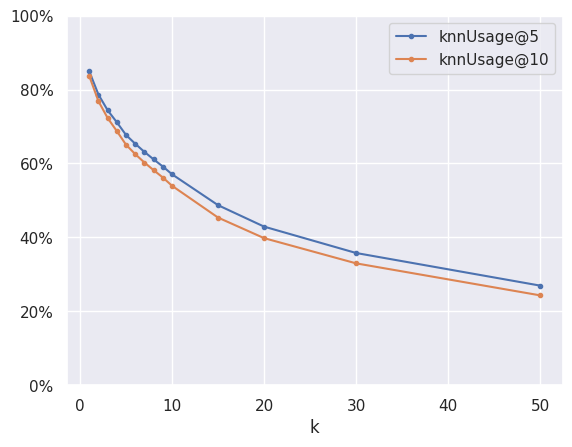

In [357]:
import matplotlib.ticker as mtick

ax = (mdf.groupby('k')[['knnUsage@5', 'knnUsage@10']].mean()*100).plot(style='.-')
ax.set_ylim((0, 100))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
nbutils.download_matplotlib(ax.figure, f'11_knn_usage_k_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

Cannot show ipywidgets in text

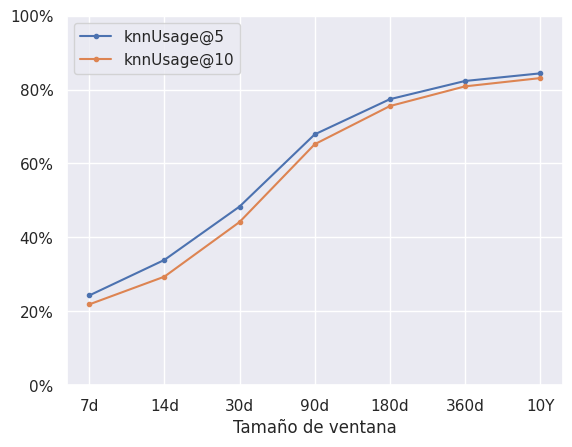

In [358]:
order = param_grid.param_grid[0]['window_size']
_toplot = (mdf.groupby('window_size')[['knnUsage@5', 'knnUsage@10']].mean()*100).loc[order]

ax = _toplot.plot(style='.-')
ax.set_ylim((0, 100))
ax.set_xlabel('Tamaño de ventana')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
nbutils.download_matplotlib(ax.figure, f'11_knn_usage_window_size_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

/tmp/ipykernel_4063225/3185427442.py:2: FutureWarning:

Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.



Cannot show ipywidgets in text

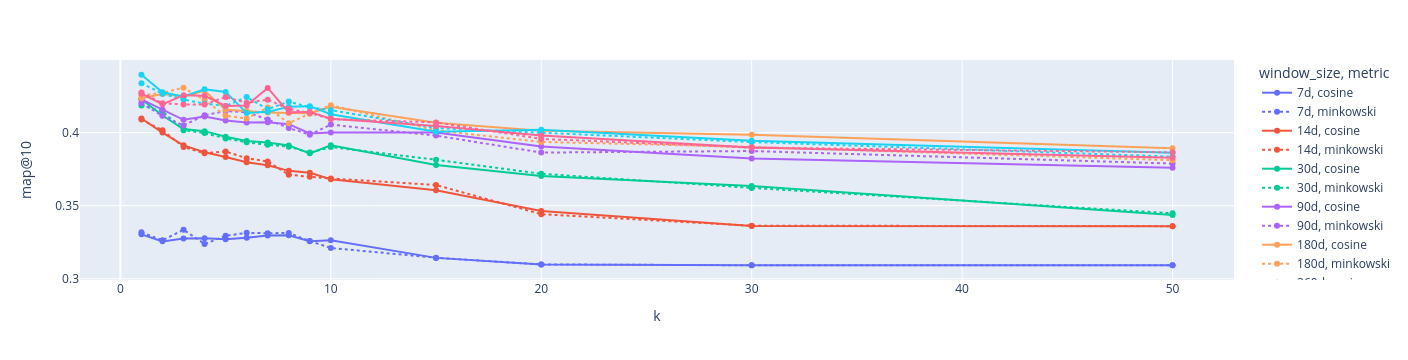

In [359]:
_toplot = mdf_mean.reset_index().copy()
_toplot['days'] = pd.to_timedelta(_toplot['window_size']).dt.days
_toplot = _toplot.sort_values(['k', 'days'])
# _toplot['color'] = _toplot['window_size'] + ',' + _toplot['metric']

fig = px.line(
    _toplot, 
    x='k', 
    y=KNN_ANALYZE_METRIC, 
    color='window_size', 
    markers=True, 
    line_dash='metric', 
    hover_data='time@10',
    # color_discrete_sequence=px.colors.sequential.Turbo,
)
display(nbutils.download_plotly(fig, f'11_knn_results_k-size_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf'))
fig

Cannot show ipywidgets in text

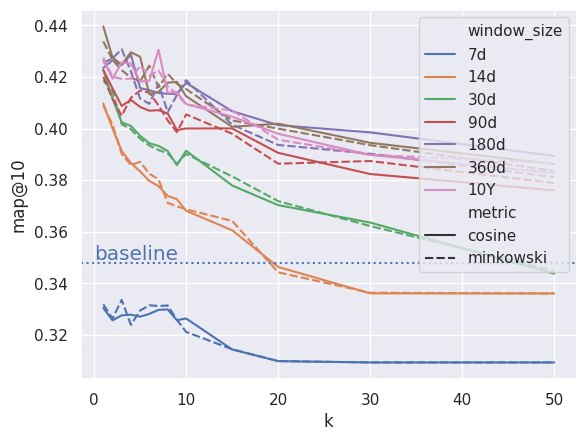

In [365]:
baseline = baseline = bdf[KNN_ANALYZE_METRIC].mean()

ax = sns.lineplot(_toplot, 
    x='k', 
    y=KNN_ANALYZE_METRIC, 
    hue='window_size', 
    # markers=True, 
    style='metric', 
    # hover_data='time@10',
)
ax.axhline(baseline, linestyle=':')
ax.text(0, baseline, "baseline", 
        color=ax.lines[-1].get_color(),
        ha='left', 
        va='bottom',
        fontsize='large',
)
# ax.set_xlabel('log')
# ax.set_ylim((0,0.7))
nbutils.download_matplotlib(ax.figure, f'11_knn_results_all_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

Cannot show ipywidgets in text

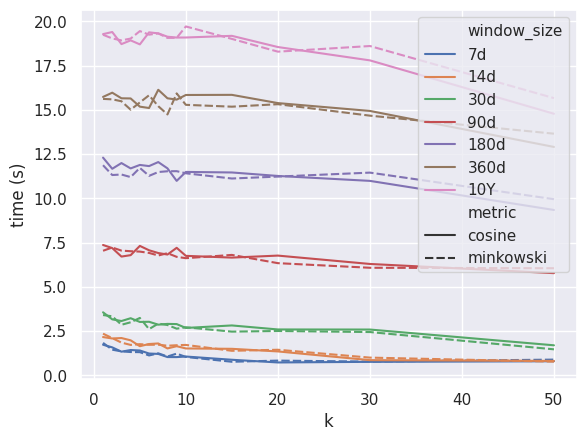

In [276]:
baseline = baseline = bdf[KNN_ANALYZE_METRIC].mean()

ax = sns.lineplot(_toplot, 
    x='k', 
    y='time@10', 
    hue='window_size', 
    # markers=True, 
    style='metric', 
    # hover_data='time@10',
)
# ax.set_xscale('log')
ax.set_ylabel('time (s)')
nbutils.download_matplotlib(ax.figure, f'11_knn_results_time_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

/tmp/ipykernel_4063225/783071194.py:2: FutureWarning:

Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.



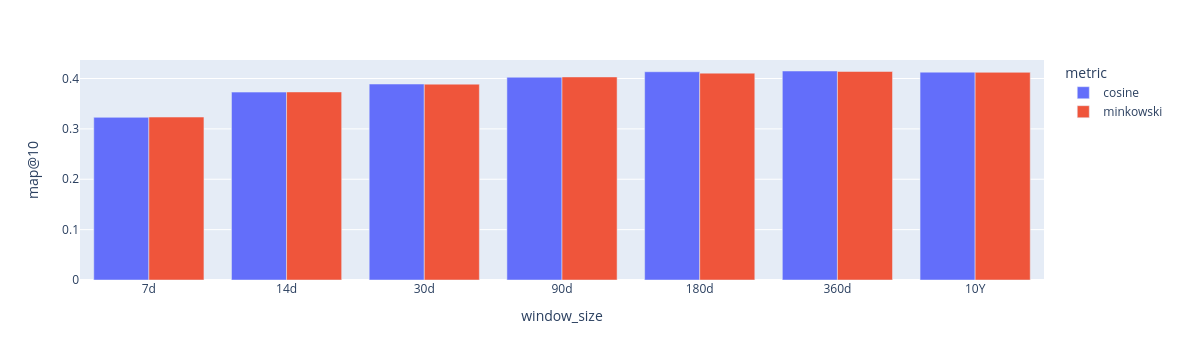

In [269]:
_toplot = mdf.groupby(['window_size', 'metric']).mean().reset_index()
_toplot['days'] = pd.to_timedelta(_toplot['window_size']).dt.days
_toplot = _toplot.sort_values('days')

px.bar(
    _toplot,
    x='window_size',
    y=KNN_ANALYZE_METRIC,
    color='metric',
    hover_data='time@10',
    # pattern_shape='metric',
    barmode='group',
)